# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=35,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-22-21/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5151 | MulticlassF1Score=0.2075
Batch-30 : CrossEntropyLoss=2.4391 | MulticlassF1Score=0.2341
Batch-45 : CrossEntropyLoss=2.4422 | MulticlassF1Score=0.2705
Batch-60 : CrossEntropyLoss=2.4500 | MulticlassF1Score=0.2950
Batch-75 : CrossEntropyLoss=2.4589 | MulticlassF1Score=0.3120
Batch-90 : CrossEntropyLoss=2.4123 | MulticlassF1Score=0.3339
Batch-105: CrossEntropyLoss=2.4077 | MulticlassF1Score=0.3539
Batch-120: CrossEntropyLoss=2.3999 | MulticlassF1Score=0.3700
Batch-135: CrossEntropyLoss=2.4159 | MulticlassF1Score=0.3826
Batch-150: CrossEntropyLoss=2.3982 | MulticlassF1Score=0.3941
Batch-165: CrossEntropyLoss=2.3916 | MulticlassF1Score=0.4088
Batch-180: CrossEntropyLoss=2.3745 | MulticlassF1Score=0.4219
Batch-195: CrossEntropyLoss=2.3524 | MulticlassF1Score=0.4384
Batch-210: CrossEntropyLoss=2.3513 | MulticlassF1Score=0.4551
Batch-225: CrossEntropyLoss=2.3452 | MulticlassF1Score=0.4698
Batch-226: CrossEntropyLoss=2.3677 | MulticlassF1Score=0.4705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3546 | MulticlassF1Score=0.6713
Batch-30 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.6734
Batch-45 : CrossEntropyLoss=2.3466 | MulticlassF1Score=0.6702
Batch-60 : CrossEntropyLoss=2.3418 | MulticlassF1Score=0.6739
Batch-63 : CrossEntropyLoss=2.3608 | MulticlassF1Score=0.6740

Training   : Mean CrossEntropyLoss = 2.4233 | Mean MulticlassF1Score = 0.3486
Validation : Mean CrossEntropyLoss = 2.3501 | Mean MulticlassF1Score = 0.6717

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3389 | MulticlassF1Score=0.6732
Batch-30 : CrossEntropyLoss=2.3540 | MulticlassF1Score=0.6795
Batch-45 : CrossEntropyLoss=2.3587 | MulticlassF1Score=0.6762
Batch-60 : CrossEntropyLoss=2.3505 | MulticlassF1Score=0.6793
Batch-75 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.6835
Batch-90 : CrossEntropyLoss=2.3322 | MulticlassF1Score=0.6886
Batch-105: CrossEntropyLoss=2.3307 | MulticlassF1Score=0.6936
Batch-120: CrossEntropyLoss=2.3479 | MulticlassF1Score=0.6966
Batch-135: CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7015
Batch-150: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7080
Batch-165: CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7133
Batch-180: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7188
Batch-195: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7238
Batch-210: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7282
Batch-225: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7324
Batch-226: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7325

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7920
Batch-30 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7878
Batch-45 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7907
Batch-60 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7896
Batch-63 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.7899

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3317 | Mean MulticlassF1Score = 0.6986
Validation : Mean CrossEntropyLoss = 2.3136 | Mean MulticlassF1Score = 0.7896

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7793
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.7860
Batch-45 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7882
Batch-60 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7899
Batch-75 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7906
Batch-90 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7907
Batch-105: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7908
Batch-120: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7911
Batch-135: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7915
Batch-150: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7924
Batch-165: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.7933
Batch-180: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7936
Batch-195: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7933
Batch-210: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7934
Batch-225: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7934
Batch-226: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7935

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7909
Batch-30 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7930
Batch-45 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7944
Batch-60 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7932
Batch-63 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7929

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3120 | Mean MulticlassF1Score = 0.7899
Validation : Mean CrossEntropyLoss = 2.3123 | Mean MulticlassF1Score = 0.7931

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7979
Batch-30 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7985
Batch-45 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7959
Batch-60 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7968
Batch-75 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7957
Batch-90 : CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7976
Batch-105: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7977
Batch-120: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7969
Batch-135: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7969
Batch-150: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7972
Batch-165: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.7985
Batch-180: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8005
Batch-195: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8015
Batch-210: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8026
Batch-225: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8039
Batch-226: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8039

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8131
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8139
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8141
Batch-60 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8146
Batch-63 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8147

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3086 | Mean MulticlassF1Score = 0.7982
Validation : Mean CrossEntropyLoss = 2.3053 | Mean MulticlassF1Score = 0.8135

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8206
Batch-30 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8200
Batch-45 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8201
Batch-60 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8199
Batch-75 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8194
Batch-90 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8195
Batch-105: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8190
Batch-120: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8190
Batch-135: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8192
Batch-150: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8195
Batch-165: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8199
Batch-180: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8191
Batch-195: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8190
Batch-210: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8189
Batch-225: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8198
Batch-226: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8198

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8175
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8198
Batch-45 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8173
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8175
Batch-63 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8176

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3036 | Mean MulticlassF1Score = 0.8191
Validation : Mean CrossEntropyLoss = 2.3045 | Mean MulticlassF1Score = 0.8190

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8189
Batch-30 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8202
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8243
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8230
Batch-75 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8238
Batch-90 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8231
Batch-105: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8219
Batch-120: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8226
Batch-135: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8229
Batch-150: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8221
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8219
Batch-180: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8220
Batch-195: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8220
Batch-210: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8221
Batch-225: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8225
Batch-226: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8225

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8222
Batch-30 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8176
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8175
Batch-60 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8171
Batch-63 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8174

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3027 | Mean MulticlassF1Score = 0.8220
Validation : Mean CrossEntropyLoss = 2.3044 | Mean MulticlassF1Score = 0.8210

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8277
Batch-30 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8242
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8226
Batch-60 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8228
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8225
Batch-90 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8227
Batch-105: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8232
Batch-120: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8233
Batch-135: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8250
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8284
Batch-165: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8318
Batch-180: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8343
Batch-195: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8364
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8381
Batch-225: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8399
Batch-226: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8400

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8613
Batch-30 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8608
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8617
Batch-60 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8605
Batch-63 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8597

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8274
Validation : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8609

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8668
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8711
Batch-45 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8683
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8693
Batch-75 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8693
Batch-90 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8685
Batch-105: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8684
Batch-120: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8680
Batch-135: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8684
Batch-150: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8683
Batch-165: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8677
Batch-180: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8680
Batch-195: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8674
Batch-210: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8675
Batch-225: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8677
Batch-226: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8652
Batch-30 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8656
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8639
Batch-60 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8630
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8630

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2889 | Mean MulticlassF1Score = 0.8681
Validation : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8652

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8676
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8695
Batch-45 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8701
Batch-60 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8697
Batch-75 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8699
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8703
Batch-105: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8704
Batch-120: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8697
Batch-135: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8701
Batch-150: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8702
Batch-165: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8699
Batch-180: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8702
Batch-195: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8709
Batch-210: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8704
Batch-225: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8705
Batch-226: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8716
Batch-30 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8681
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8657
Batch-60 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8653
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8649

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2879 | Mean MulticlassF1Score = 0.8694
Validation : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8679

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8764
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8722
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8748
Batch-60 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8743
Batch-75 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8741
Batch-90 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8738
Batch-105: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8743
Batch-120: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8745
Batch-135: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8736
Batch-150: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8734
Batch-165: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8739
Batch-180: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8731
Batch-195: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8731
Batch-210: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8727
Batch-225: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8730
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8730

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8602
Batch-30 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8633
Batch-45 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8653
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8659
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8657

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8740
Validation : Mean CrossEntropyLoss = 2.2895 | Mean MulticlassF1Score = 0.8633

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8749
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8743
Batch-45 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8750
Batch-60 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8746
Batch-75 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8739
Batch-90 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8746
Batch-105: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8743
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8745
Batch-135: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8747
Batch-150: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8758
Batch-165: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8765
Batch-180: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8776
Batch-195: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8781
Batch-210: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8781
Batch-225: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8787
Batch-226: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8788

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8781
Batch-30 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8774
Batch-60 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8765
Batch-63 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8768

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8757
Validation : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8788

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8868
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8863
Batch-45 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8865
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8861
Batch-75 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8849
Batch-90 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8847
Batch-105: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8856
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8859
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8863
Batch-150: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8871
Batch-165: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8871
Batch-180: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8869
Batch-195: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8869
Batch-210: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8869
Batch-225: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8869
Batch-226: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8868

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8767
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8780
Batch-45 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8756
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8772
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8770

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8862
Validation : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8761

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8889
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8915
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8905
Batch-75 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8898
Batch-90 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8885
Batch-105: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8887
Batch-120: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8892
Batch-135: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8885
Batch-150: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8888
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8888
Batch-180: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8886
Batch-195: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8885
Batch-210: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8882
Batch-225: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8878
Batch-226: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8878

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8745
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8781
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8773
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8770
Batch-63 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8771

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8892
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8759

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8874
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8860
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.8864
Batch-75 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8863
Batch-90 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.8872
Batch-105: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8870
Batch-120: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8879
Batch-135: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8876
Batch-150: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8881
Batch-165: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8883
Batch-180: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8879
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.8885
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8886
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8889
Batch-226: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8889

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8715
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8756
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8790
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8778
Batch-63 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8772

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8873
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8754

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8932
Batch-30 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8892
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8893
Batch-75 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8892
Batch-90 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8893
Batch-105: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8897
Batch-120: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8897
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8900
Batch-150: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8903
Batch-165: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8901
Batch-180: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8901
Batch-195: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8913
Batch-210: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8926
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8940
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.8941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8985
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8950
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8971
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8983
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8984

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8906
Validation : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8984

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9160
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9155
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9138
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9135
Batch-90 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9123
Batch-105: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9112
Batch-120: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9117
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9118
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9126
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9129
Batch-180: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9131
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9132
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9135
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9137
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9137

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9040
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9049
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9042
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9036
Batch-63 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9033

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9134
Validation : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9043

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9163
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9254
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9259
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9261
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9263
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9263
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9262
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9263
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9265
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9263
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9263
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9261
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9261

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9105
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9133
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9125
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9122

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9247
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9121

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9280
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9285
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9283
Batch-90 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9284
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9278
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9278
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9278
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9278
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9281
Batch-180: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9282
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9283
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9285
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9282
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9283

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9165
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9142
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9134
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9136

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9284
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9147

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9273
Batch-75 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9273
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9274
Batch-105: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9275
Batch-120: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9277
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9279
Batch-150: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9282
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9283
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9285
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9288
Batch-210: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9291
Batch-225: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9291

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9125
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9122
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9123
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9126
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9128

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9277
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9131

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9298
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9298
Batch-75 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9300
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9303
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9300
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9297
Batch-135: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9303
Batch-150: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9303
Batch-165: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9303
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9300
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9298
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9295
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9295

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9137
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9135
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9129

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9295
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9138

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9330
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9318
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9299
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9302
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9305
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9308
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9306
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9306
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9306
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9303
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9299
Batch-226: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9300

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9108
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9126
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9131
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9113
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9118

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9307
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9116

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9284
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9302
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9283
Batch-75 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9290
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9297
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9289
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9285
Batch-135: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9283
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9280
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9288
Batch-180: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9286
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9281
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9286
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9290

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9166
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9169
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9168
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9170

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9292
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9157
Patience = 1/50❗

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9343
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9347
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9344
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9341
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9345
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9341
Batch-120: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9339
Batch-135: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9339
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9339
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9338
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9335
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9334
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9336
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9336

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9201
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9194
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9179
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9189

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9339
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9177

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9328
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9324
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9330
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9334
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9340
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9343
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9342
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9342
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9342
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9343
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9344
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9345
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9348
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9351
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9354
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9354

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9215
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9201
Batch-63 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9198

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9338
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9196

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9398
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9392
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9380
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9380
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9377
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9375
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9384
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9202

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9381
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9387
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9384
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9383
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9381
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9384
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9385
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9385

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9220

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9391
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9402
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9400
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9399
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9203

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9396
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9400
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9396
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9231

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9405
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9410
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9409
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9246

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9411
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9415
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9409
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9215

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9410
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9410
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9216

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9191
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9409
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9411
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9417
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9415
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9413

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9238

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9416
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9412
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9226

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9242

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9419
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9421
Batch-135: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9236

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9430
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9434
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9434
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9286

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9453
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9454
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9246

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9466
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9462
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9457
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9254

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9461
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9462
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9483

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9456

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9661
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9657
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9657
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9657
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9658
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9461

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9444

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9669
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9432

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9670

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9451

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9668
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9450

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9462
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9458

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9473

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9459

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9461
Patience = 3/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9465

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465
Patience = 4/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9458

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9490

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9470

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2639
Best MulticlassF1Score validation : 0.9694
Best MulticlassF1Score validation : 0.9470
Training duration                 : 2.7647 minutes.
Training date                     : 2022-10-19 10:10:53.825927+08:00


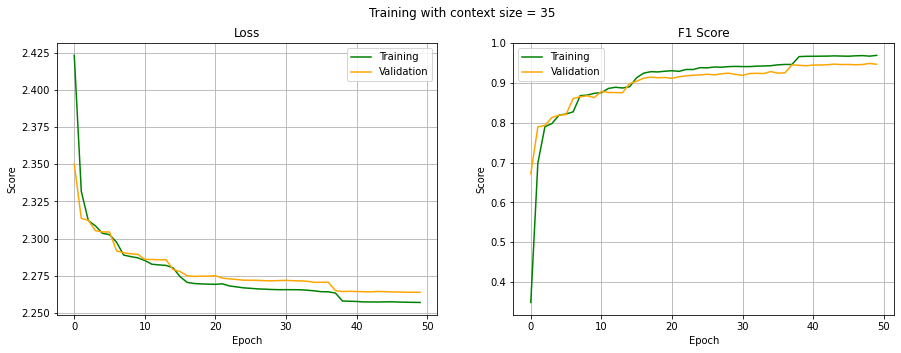

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9692, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9692, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9483, device='cuda:0'))

## Heatmap

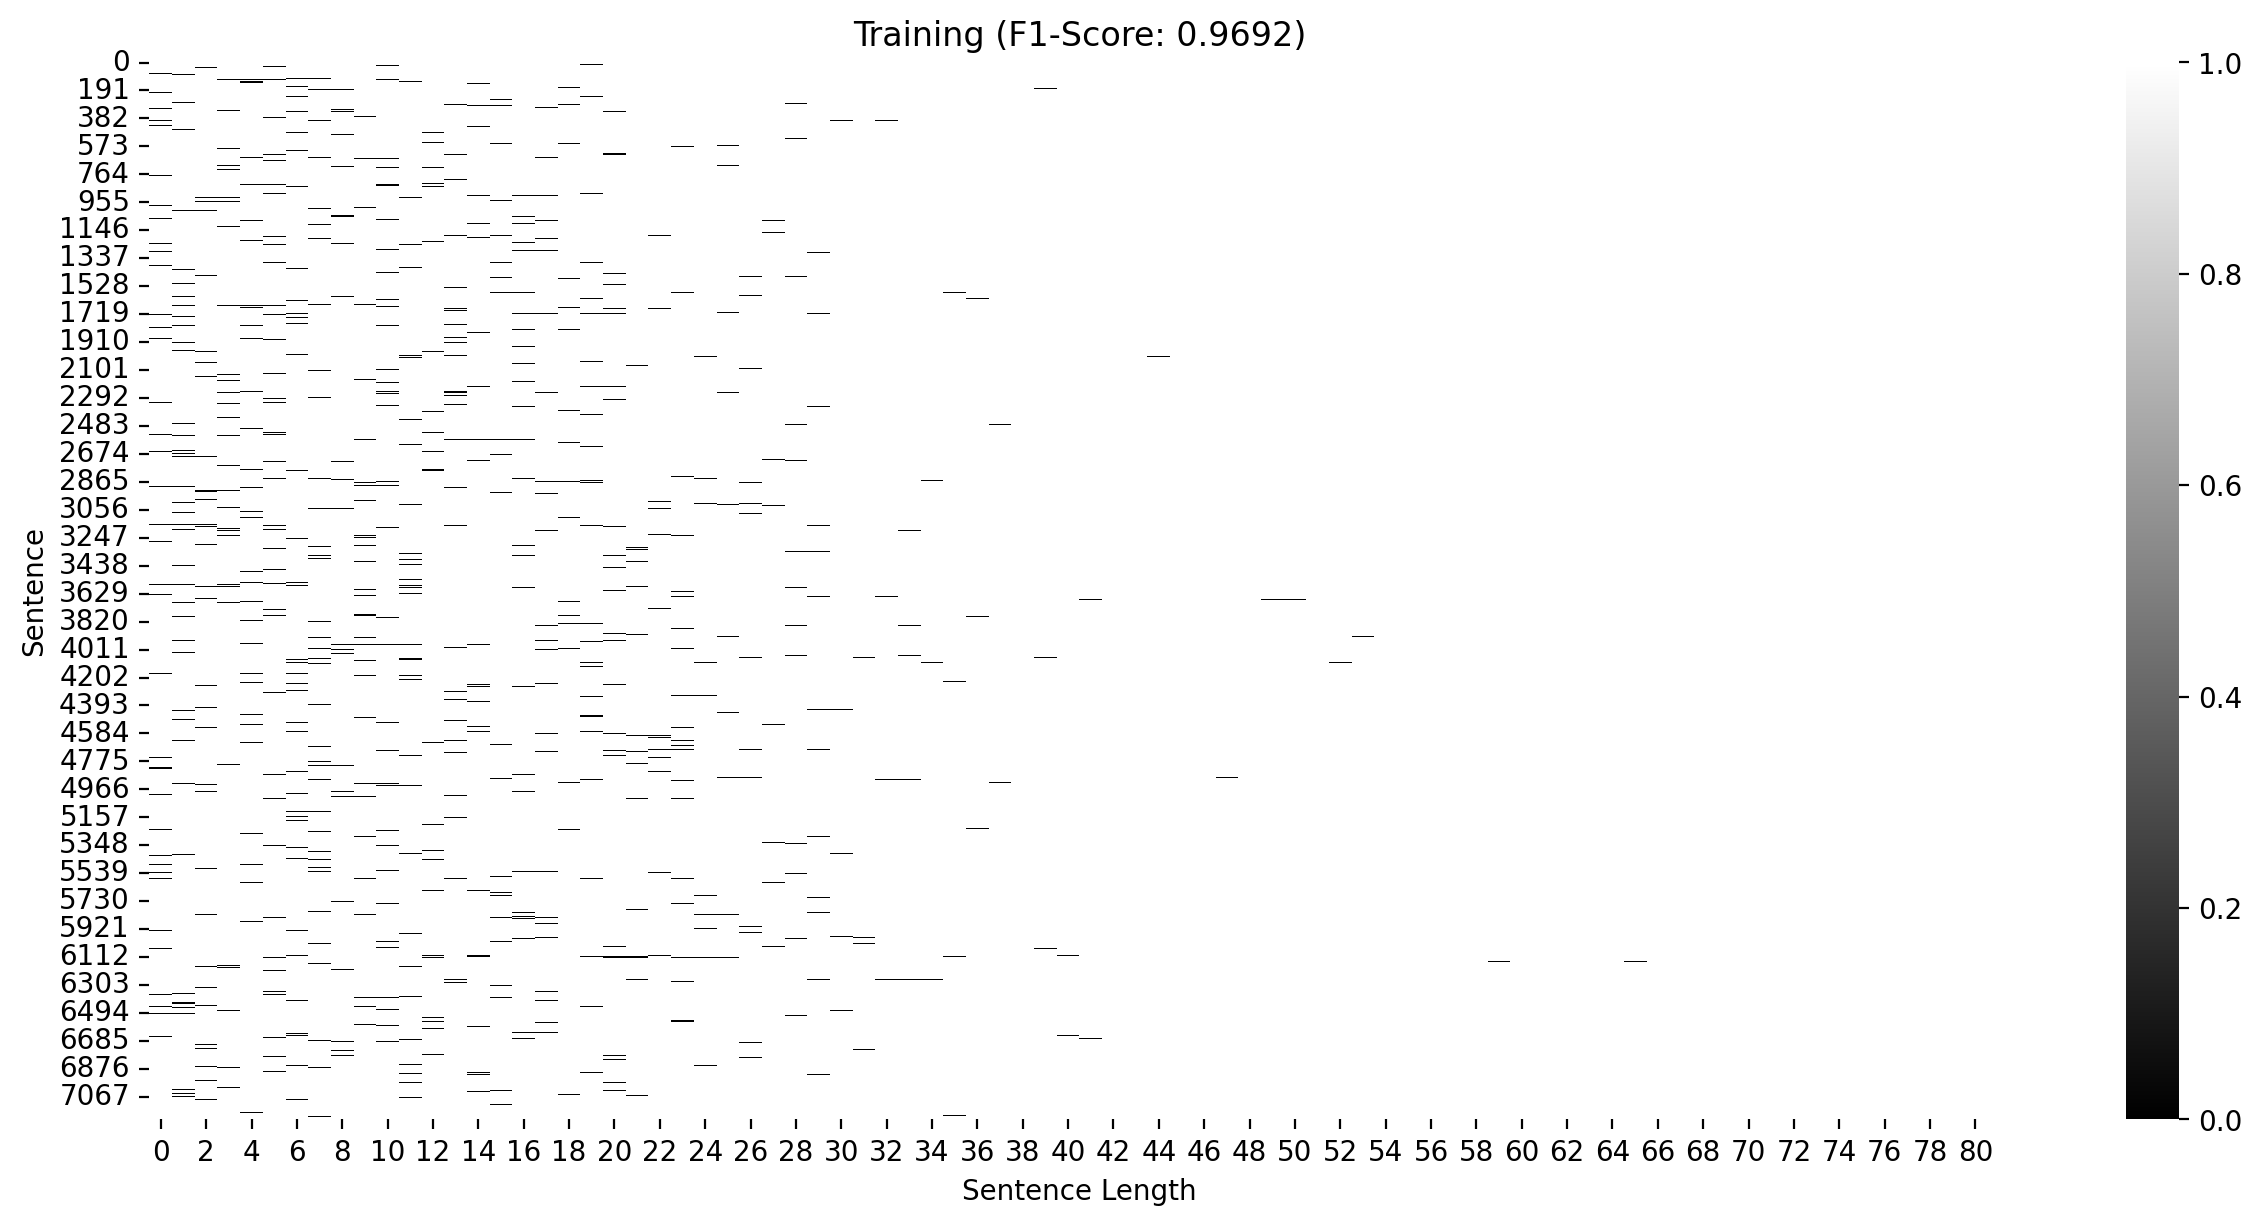

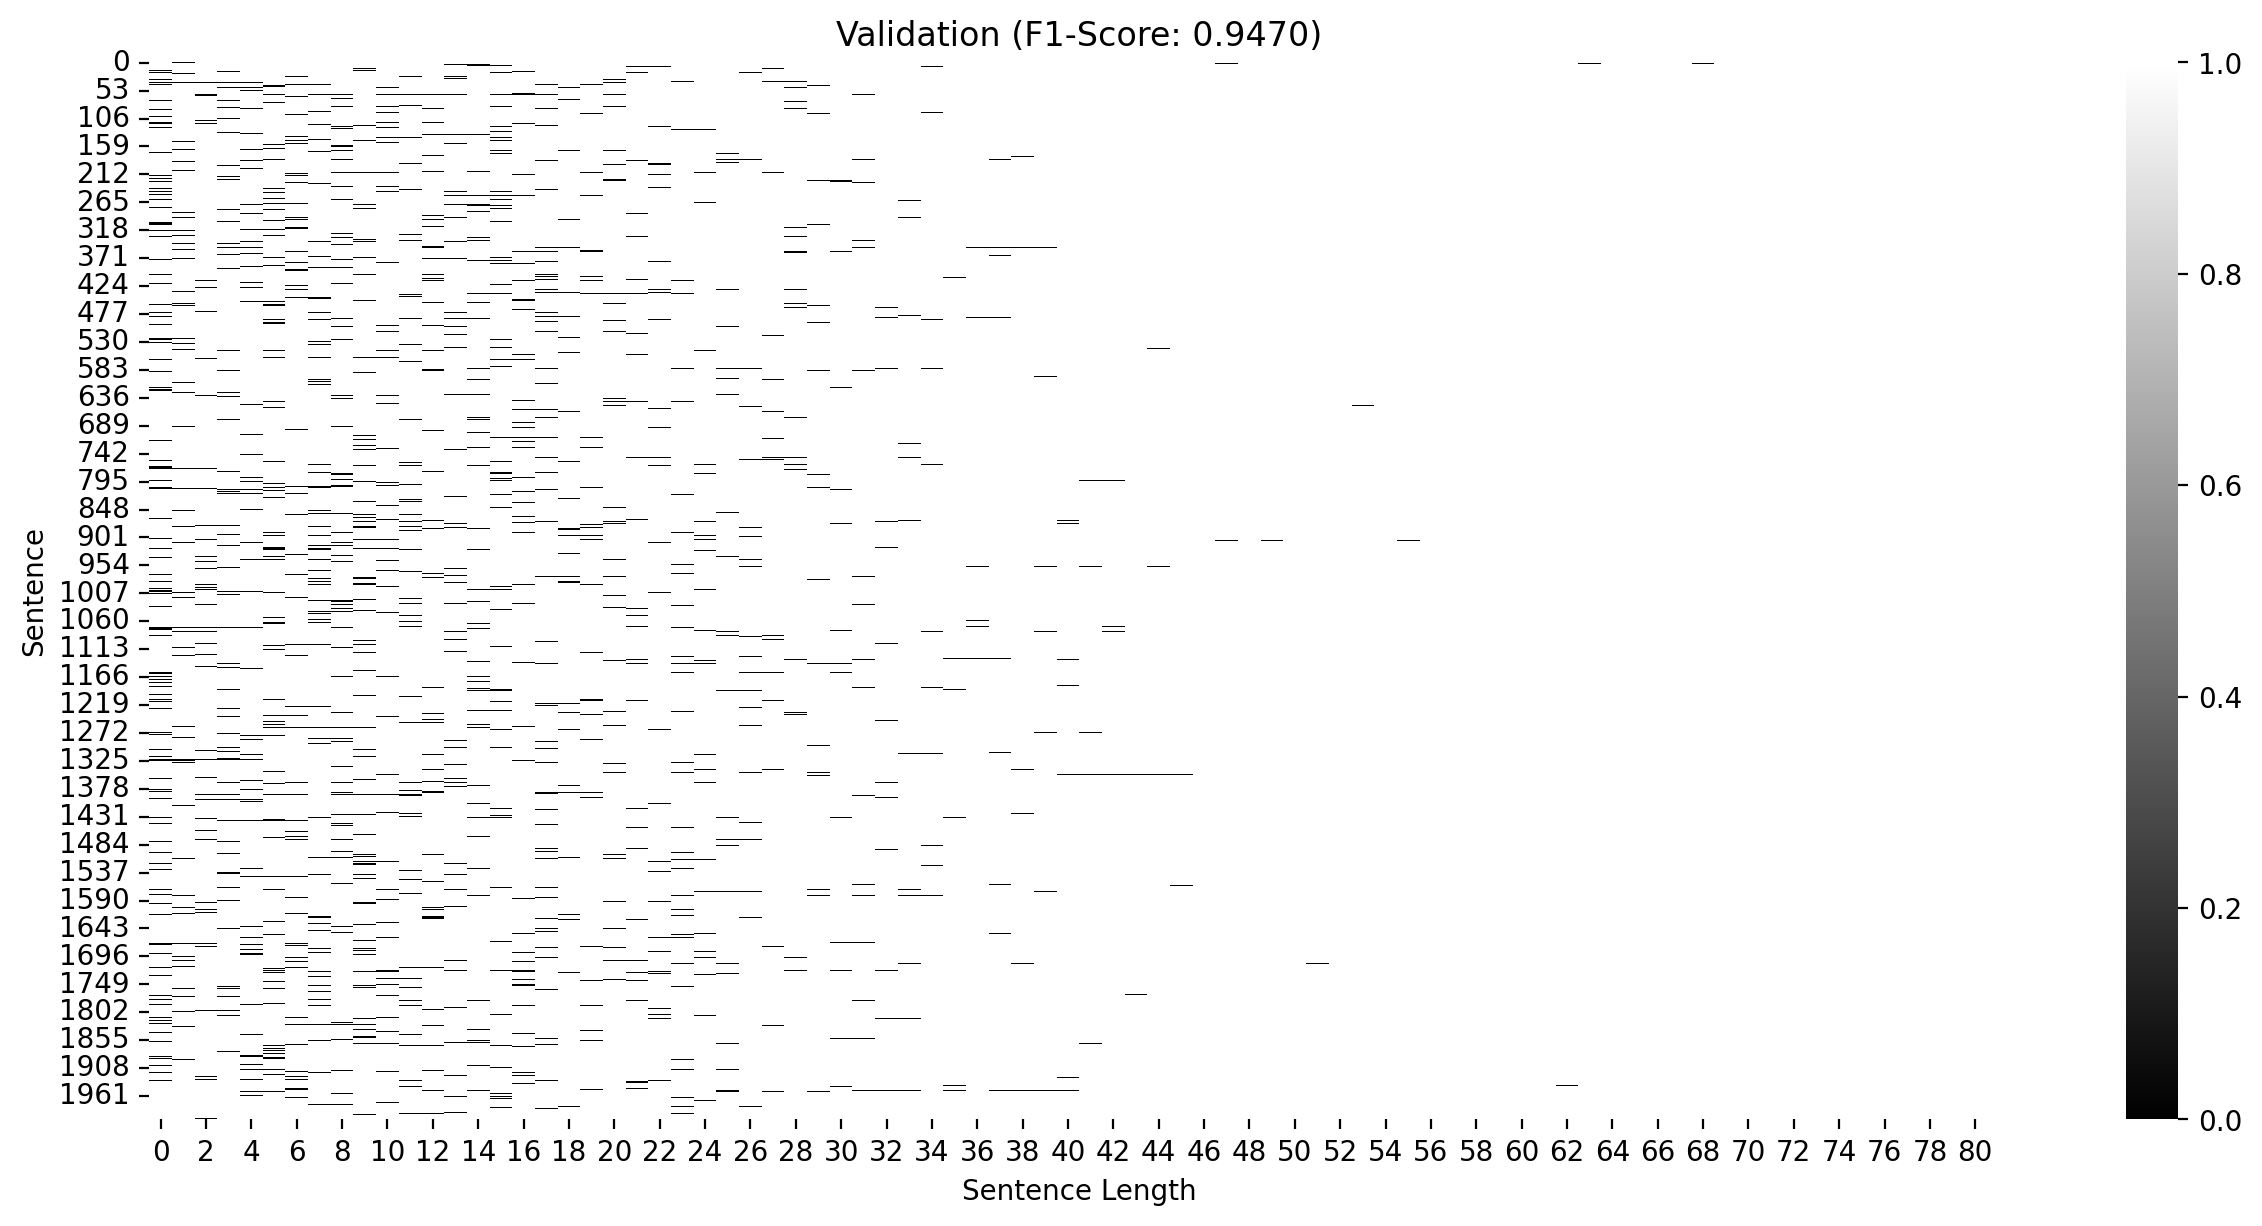

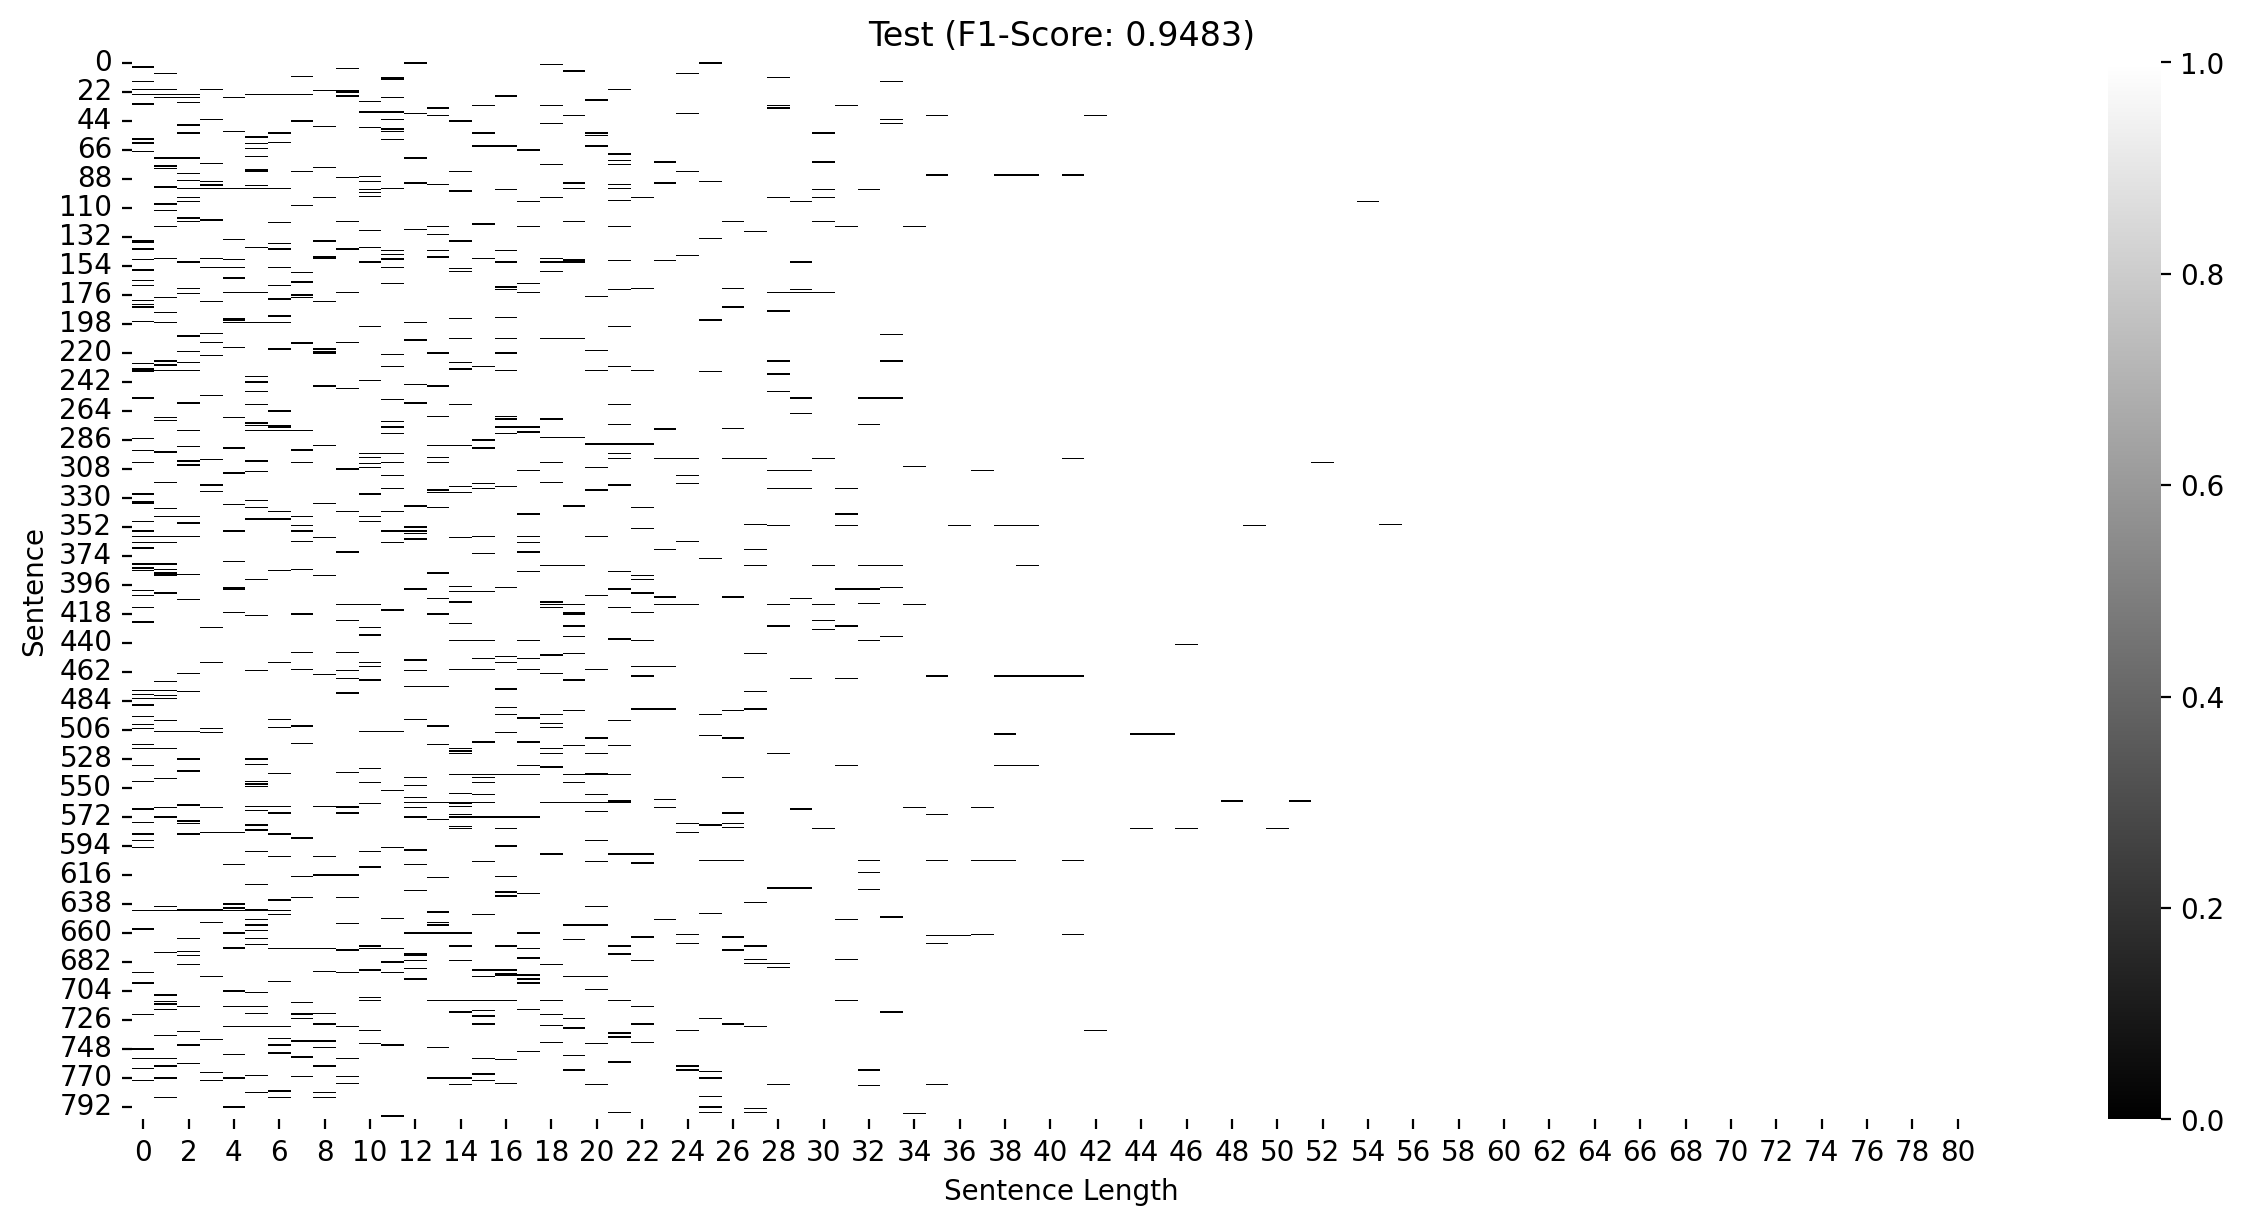

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


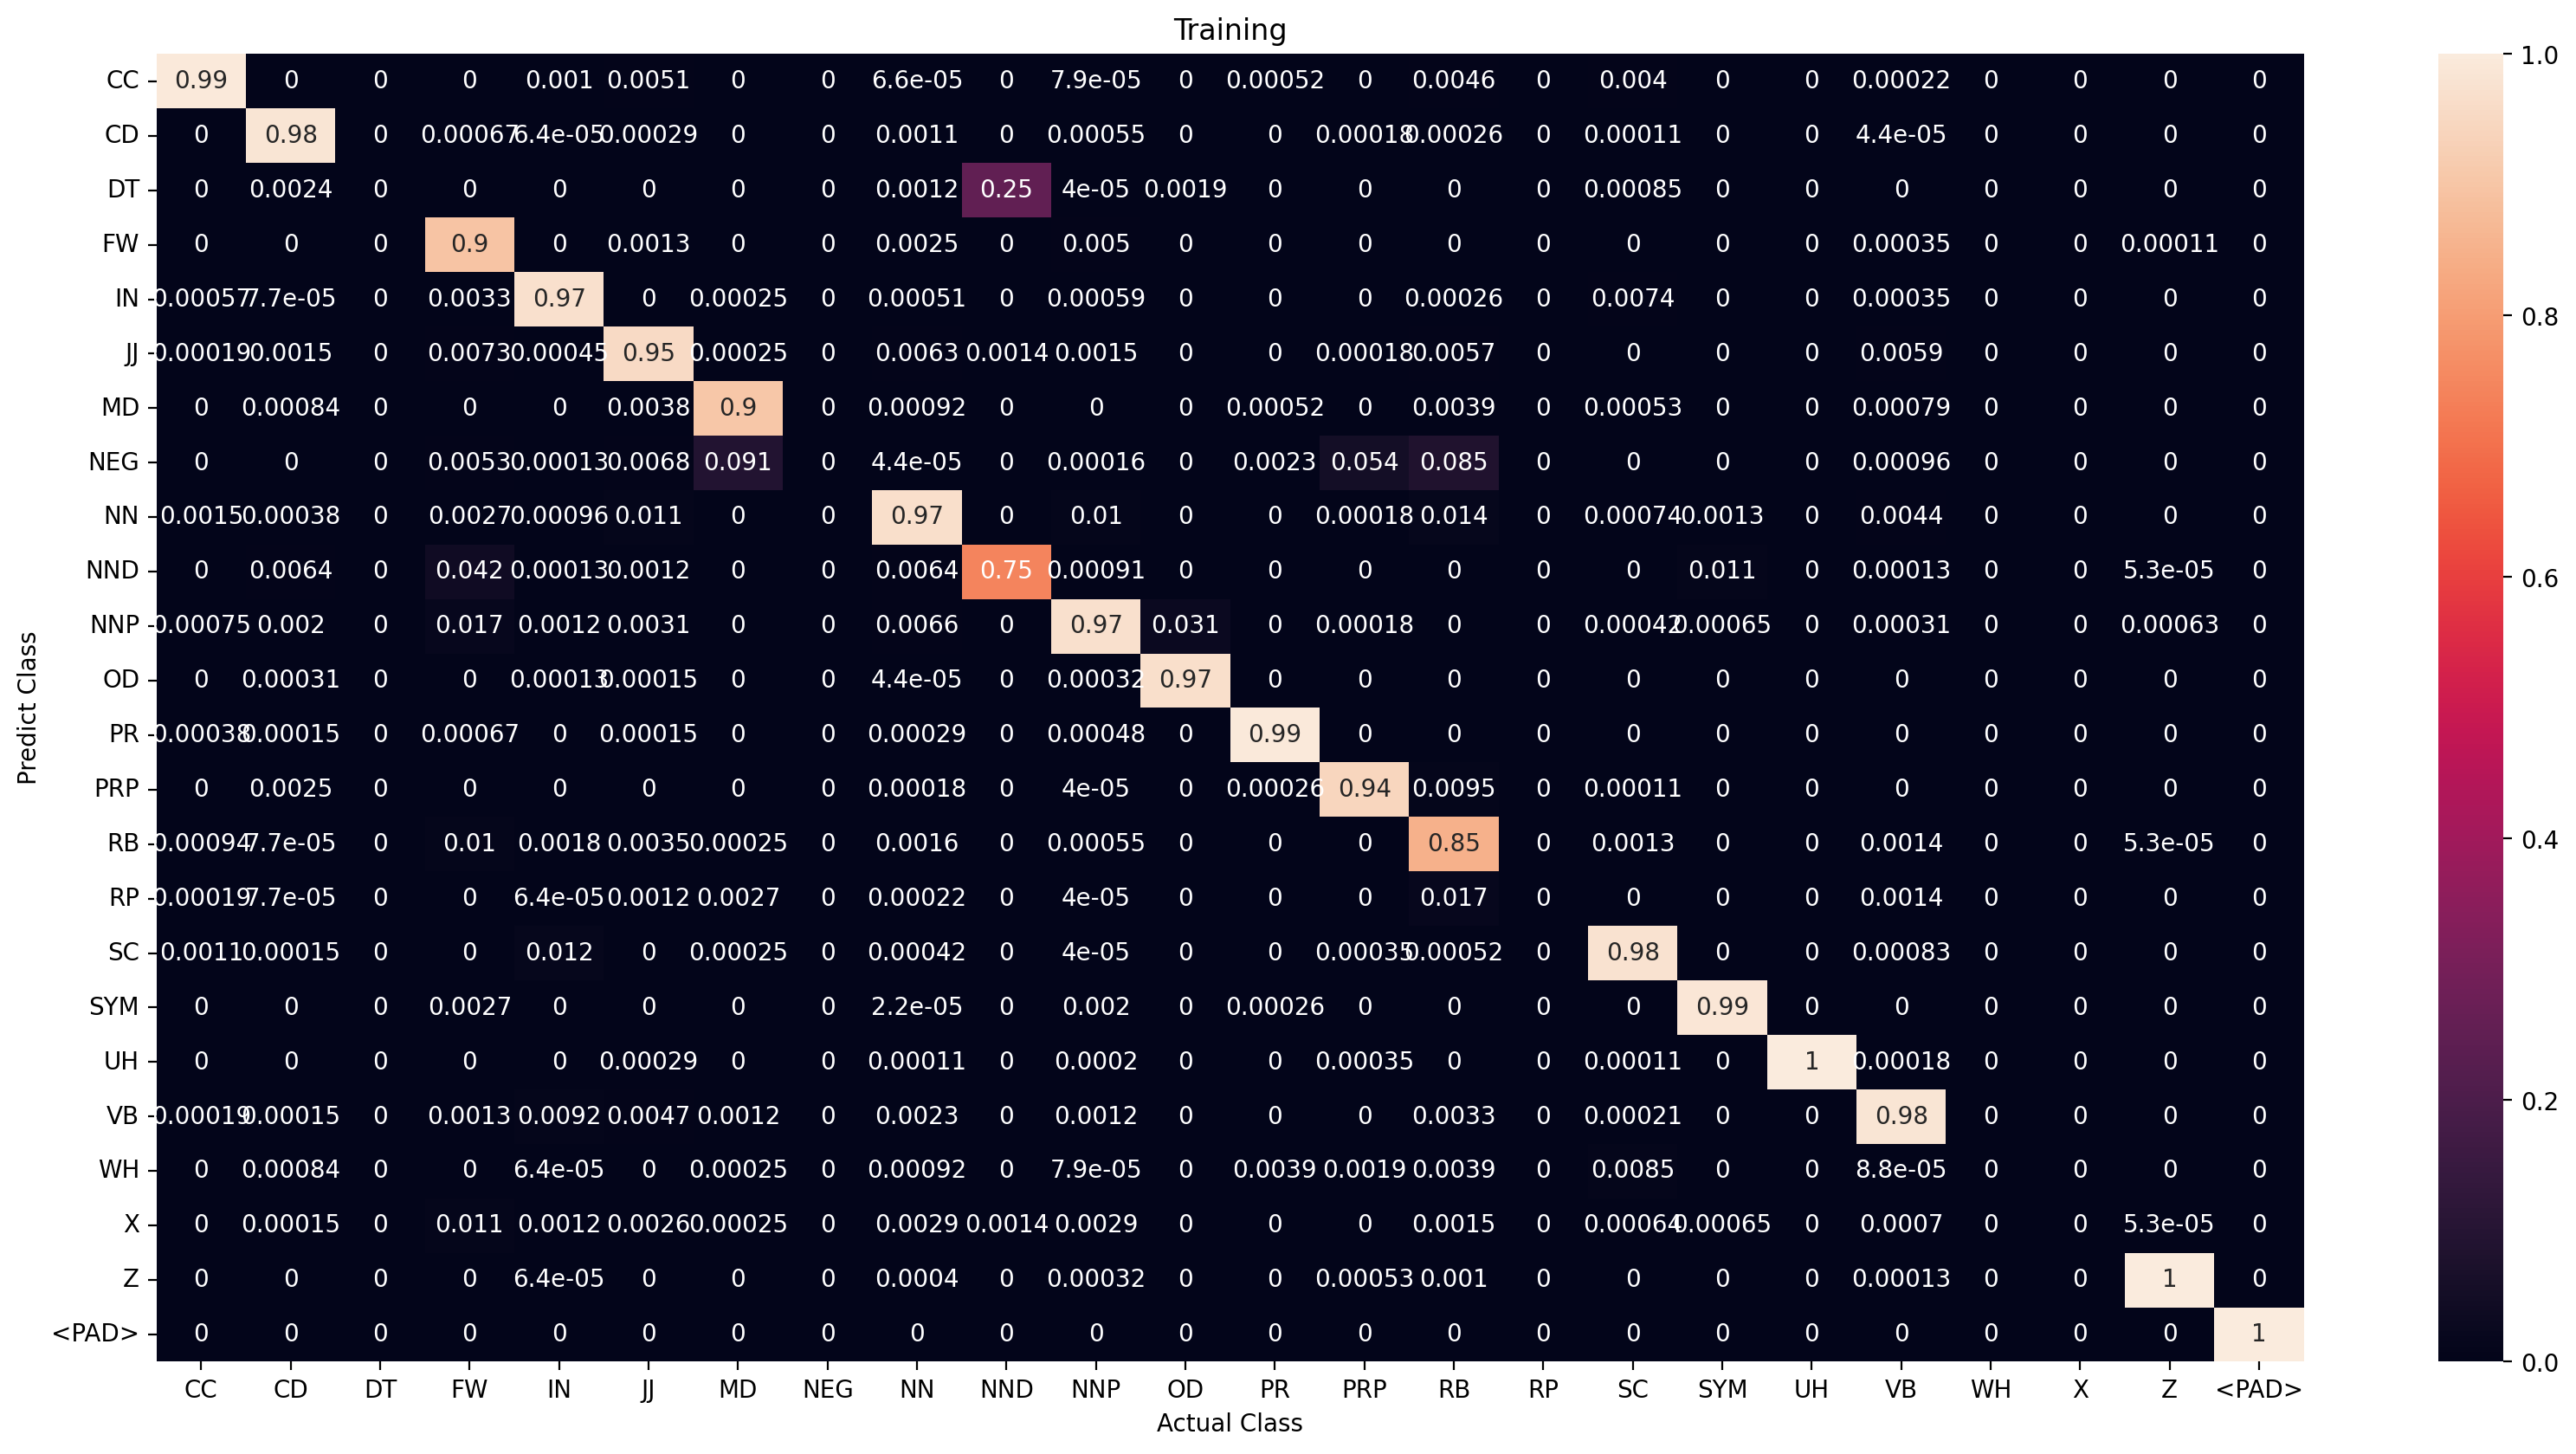

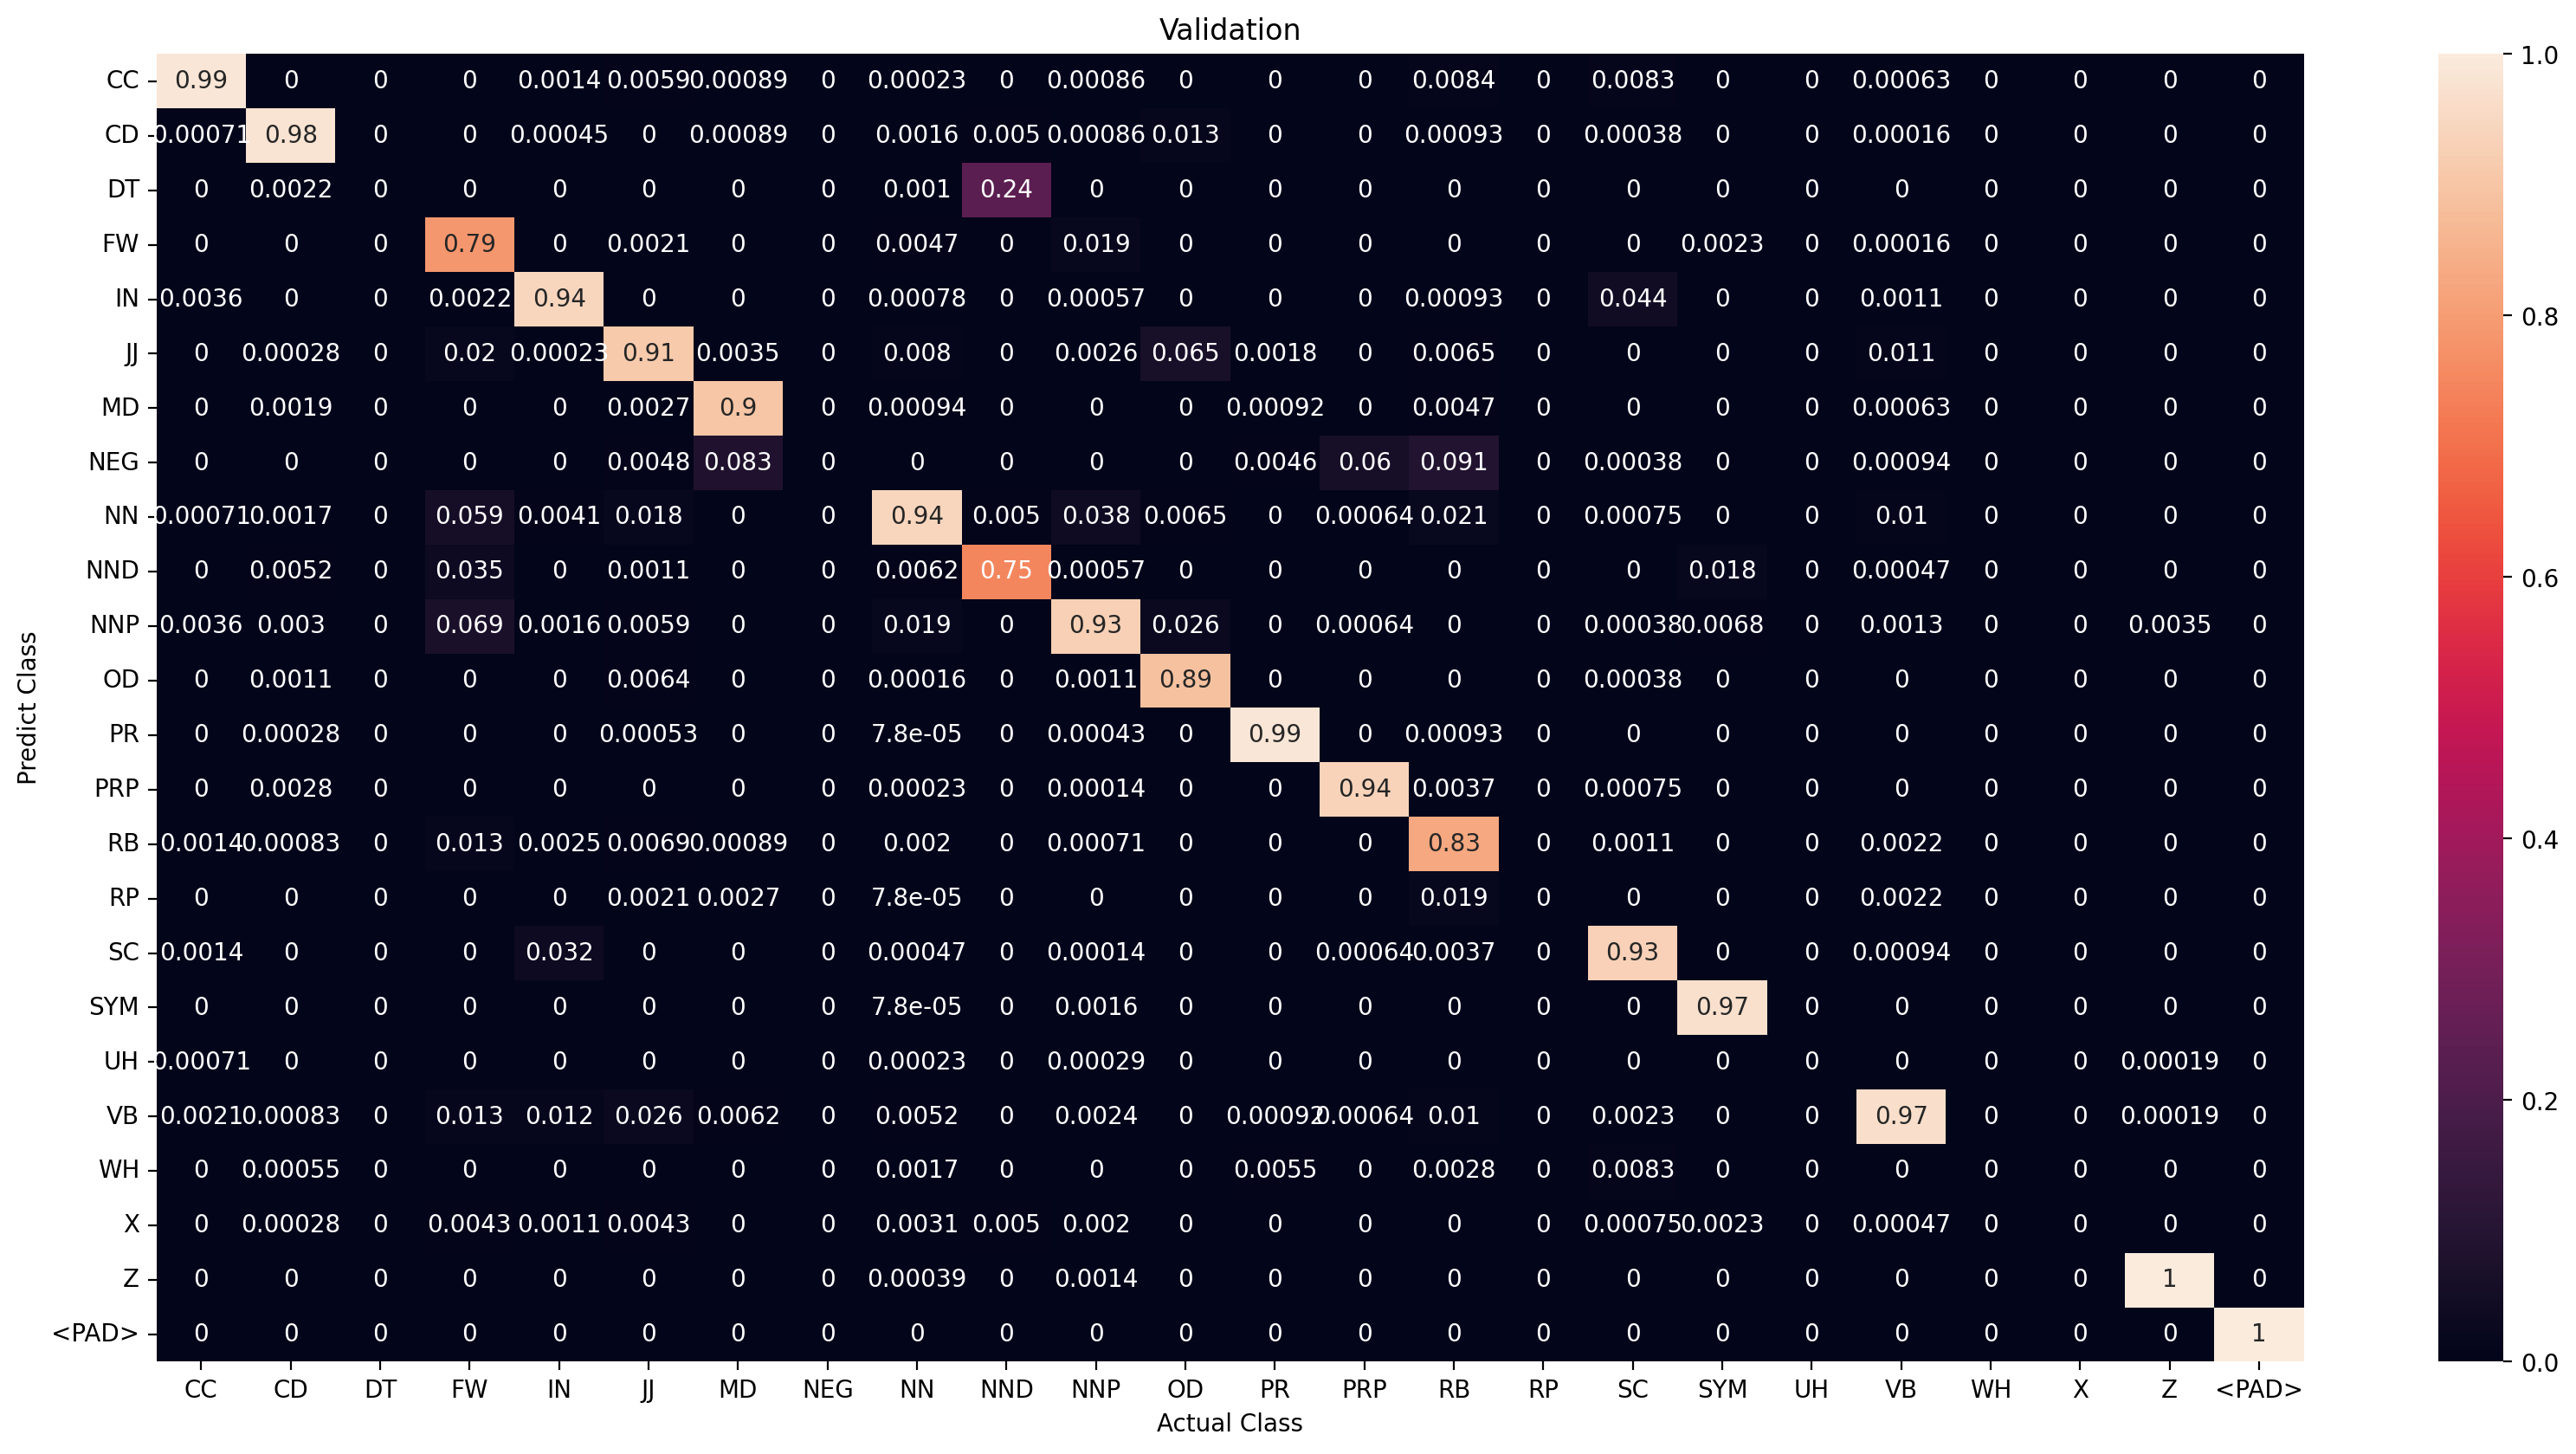

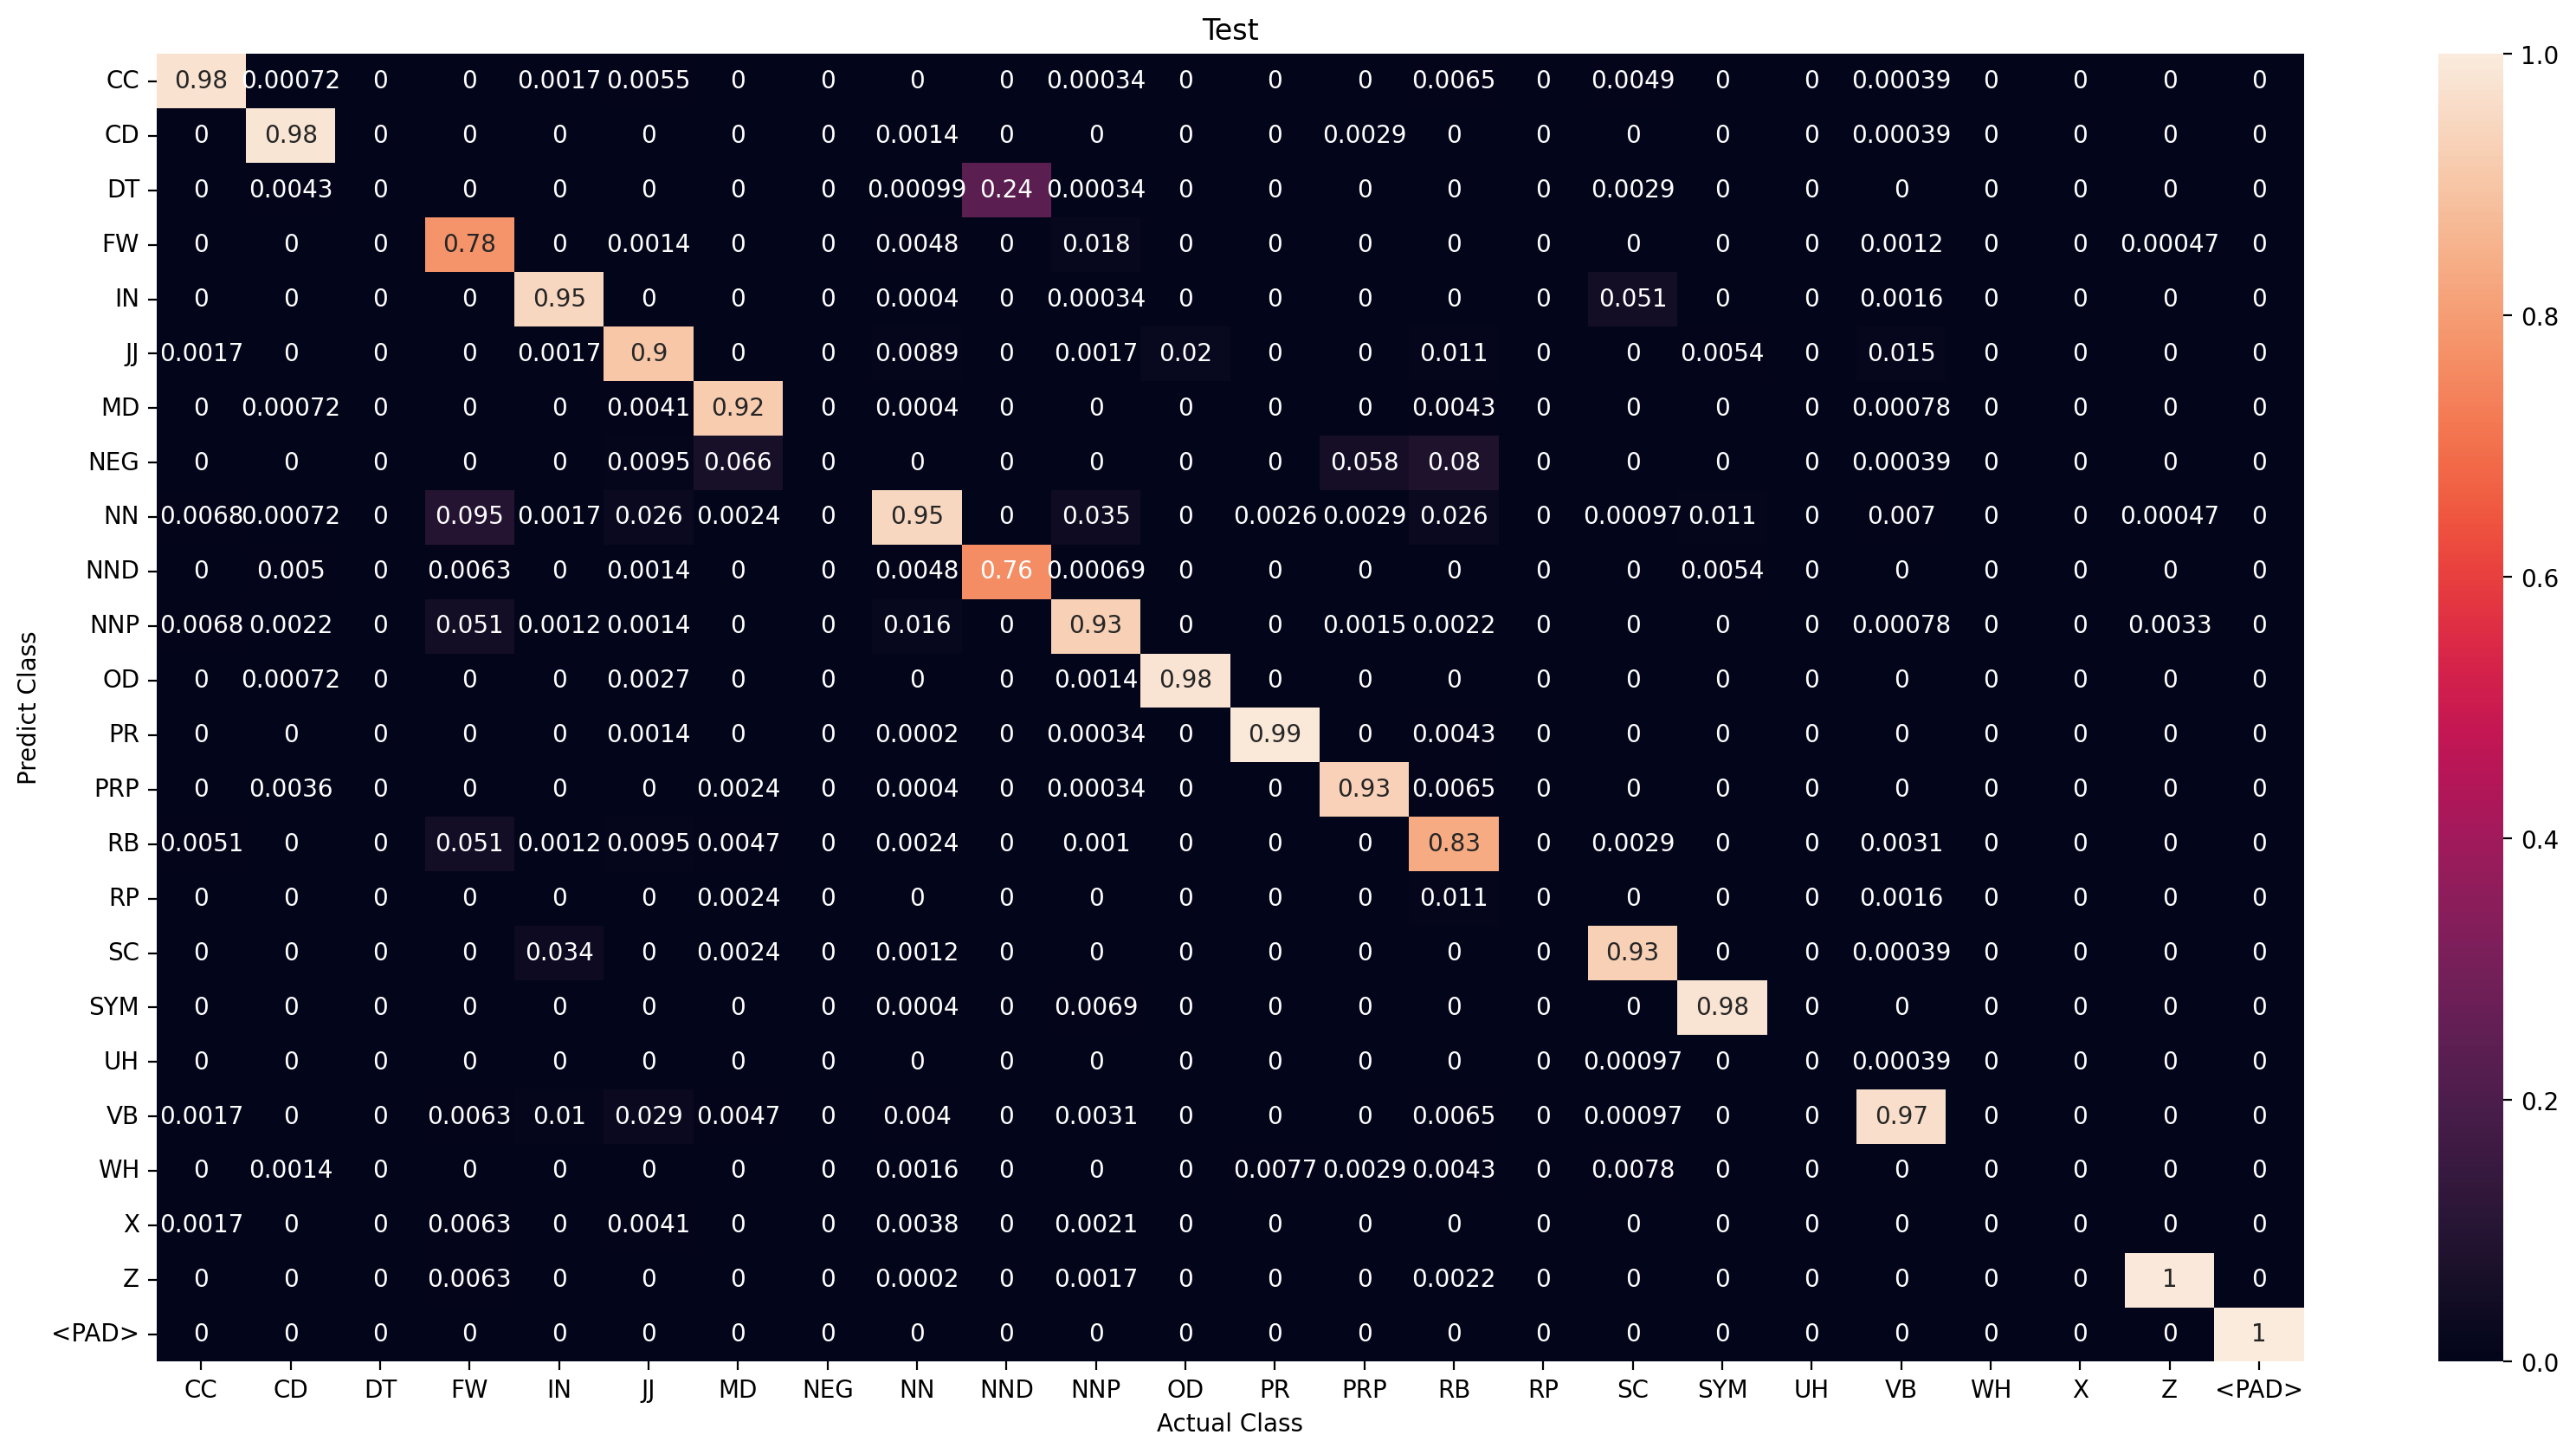

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5278       | CC    : 119      |
| CD    : 12862  | CD    : 12792      | CD    : 70       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1345       | FW    : 260      |
| IN    : 15290  | IN    : 15163      | IN    : 127      |
| JJ    : 7025   | JJ    : 6503       | JJ    : 522      |
| MD    : 3798   | MD    : 3679       | MD    : 119      |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43935      | NN    : 537      |
| NND   : 1033   | NND   : 542        | NND   : 491      |
| NNP   : 25007  | NNP   : 24569      | NNP   : 438      |
| OD    : 519    | OD    : 502        | OD    : 17       |
| PR    : 3880   | PR    : 3849       | PR    : 31       |
| PRP   : 5449   | PRP   : 5369       | PRP   : 80       |
| RB    : 3502   | RB    : 3297       | RB    : 205      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11124
Wrong prediction            : 847
Percentage correct oov pred : 92.92456770528777

Validation
Number OOV token            : 3190
Correct prediction          : 2851
Wrong prediction            : 339
Percentage correct oov pred : 89.3730407523511

Test
Number OOV token            : 1401
Correct prediction          : 1242
Wrong prediction            : 159
Percentage correct oov pred : 88.6509635974304



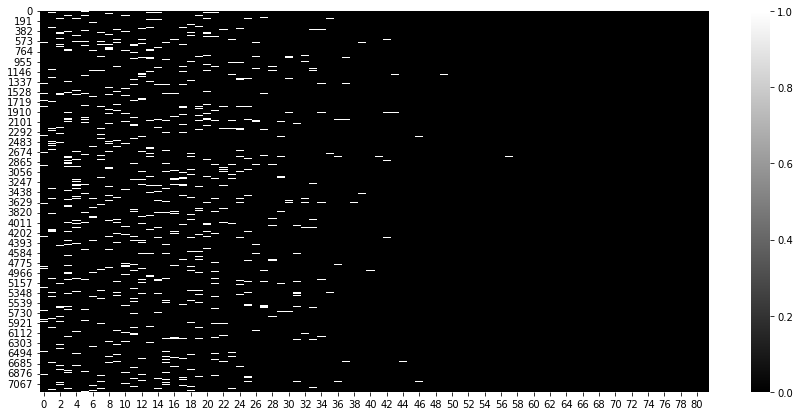

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

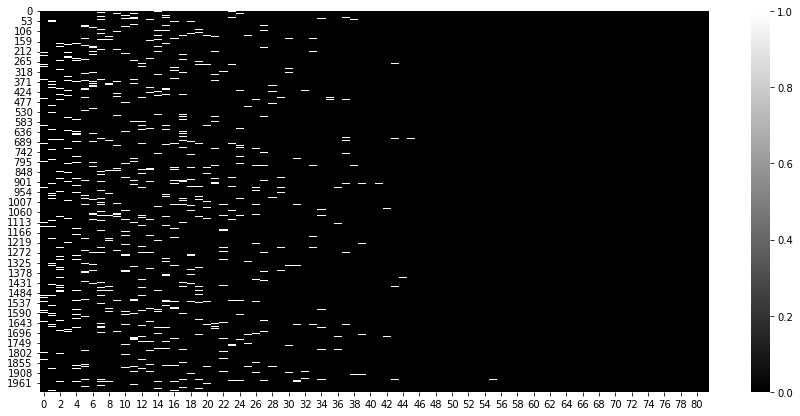

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

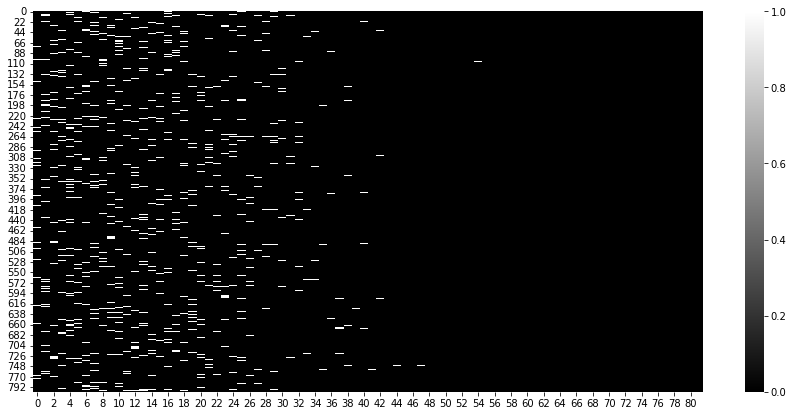

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);